In [8]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch


In [9]:
# Check for GPU availability in PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch GPU is available and activated.")
else:
    device = torch.device("cpu")
    print("Using CPU for PyTorch.")

Using CPU for PyTorch.


In [10]:
# Ensure TensorFlow GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("TensorFlow GPU is available and configured.")
else:
    print("Using CPU for TensorFlow.")

Using CPU for TensorFlow.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r'D:\Amrita Create\Induction Programme\Final_Project\data'
image_exts = ['JPEG', 'JPG', 'PNG', 'BMP']  # Allowed image file types

In [12]:
# Clean dataset
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                with Image.open(image_path) as img_file:
                    tip = img_file.format
                    if tip not in image_exts:
                        print(f'Image not in ext list: {image_path}')
                        os.remove(image_path)
            except Exception as e:
                print(f'Issue with image: {image_path}')

In [13]:
# Load and preprocess dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=32)

Found 518 files belonging to 4 classes.


In [14]:
# Augment the data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [15]:
# Normalize images
data = data.map(lambda x, y: (data_augmentation(x) / 255.0, y))


In [16]:
# Split data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [18]:
# Building an improved model
from tensorflow.keras.applications import VGG16

In [19]:
num_classes = 4

# Using Transfer Learning (Pretrained VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add Dropout for regularization
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
# Compile model with a different optimizer and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,104,580 (88.14 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
# Train with more epochs and callbacks for learning rate adjustment
logdir = r'D:\Amrita Create\Induction Programme\Final_Project\logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [22]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1164s 91s/step - accuracy: 0.4318 - loss: 1.4707 - val_accuracy: 0.5729 - val_loss: 0.9603
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 720s 66s/step - accuracy: 0.5800 - loss: 1.0641 - val_accuracy: 0.6979 - val_loss: 0.7506
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 735s 69s/step - accuracy: 0.6934 - loss: 0.8486 - val_accuracy: 0.7292 - val_loss: 0.7780
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 765s 70s/step - accuracy: 0.7151 - loss: 0.7701 - val_accuracy: 0.7708 - val_loss: 0.6988
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 746s 69s/step - accuracy: 0.7198 - loss: 0.7277 - val_accuracy: 0.7812 - val_loss: 0.6040
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 867s 81s/step - accuracy: 0.7470 - loss: 0.6643 - val_accuracy: 0.8333 - val_loss: 0.5211
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 918s 85s/step - accuracy: 0.7519 - loss: 0.6067 - val_accuracy: 0.8125 - val_loss: 0.4639
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 907s 84s/step - accuracy: 0.8145 - loss: 0.5240 - val_accuracy: 0

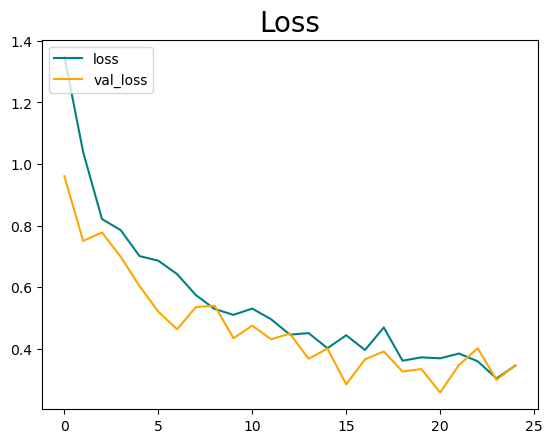

In [23]:
# Plot Performance
plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

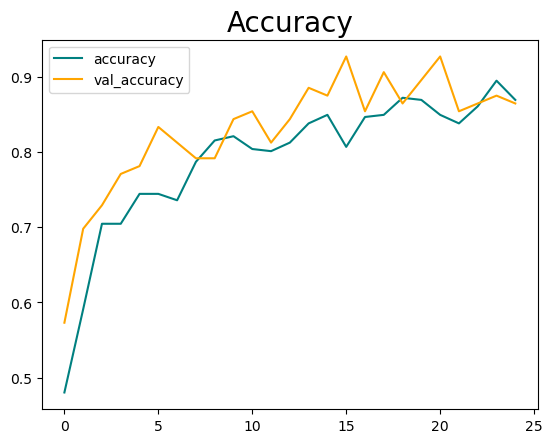

In [24]:
plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [49]:
# Evaluate the model on test data
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()  # Can be left as is; TensorFlow handles multi-class precision under the hood
re = Recall()      # Same for Recall
acc = CategoricalAccuracy()  # Use CategoricalAccuracy for multi-class accuracy

In [53]:
# Evaluate the model on test data
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=1)  # For multi-class, we take the class with the highest predicted probability
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# Display evaluation metrics
print(f'Precision: {pre.result().numpy():.4f}')
print(f'Recall: {re.result().numpy():.4f}')
print(f'Accuracy: {acc.result().numpy():.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Precision: 0.9649
Recall: 0.9649
Accuracy: 1.0000


In [79]:
# Testing the model with a new image
img = cv2.imread(r'D:\Amrita Create\Induction Programme\Final_Project\Test\rubble stone\images.jpg')
resize = tf.image.resize(img, (256, 256))
yhat = model.predict(np.expand_dims(resize / 255, axis=0))
predicted_class = np.argmax(yhat, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: [3]


In [83]:
predicted_class

array([3], dtype=int64)

In [85]:
if predicted_class == 0: 
    print(f'Predicted class is Concrete Brick')
elif predicted_class == 1: 
    print(f'Predicted class is Engineered Brick')
elif predicted_class == 2: 
    print(f'Predicted class is Burnt clay Brick')
else:
    print(f'Predicted class is Rubble Stone')

Predicted class is Rubble Stone


In [89]:
#Saving the model
from tensorflow.keras.models import load_model


In [95]:
model.save('Brick_model.keras')

In [97]:
loaded_model = load_model('Brick_model.keras')

# Check the loaded model's structure
loaded_model.summary()


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,494,474 (120.14 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 8,389,894 (32.00 MB)

In [ ]:
loaded_model.predict(np.expand_dims(resize/255, 0))
